In [1]:
from fitter import Fitter
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from sklearn.neighbors import KernelDensity
sns.set_style('darkgrid')
import scipy.stats as sp


In [5]:
point_df = pd.read_csv('points.csv',index_col=0)
# you have to renomalize this or you wont get anywhere near a PDF
point_df['Y'] = point_df['Y']/point_df['Y'].sum()
f = Fitter(point_df)


Text(0.5, 1.0, 'user provided PDF')

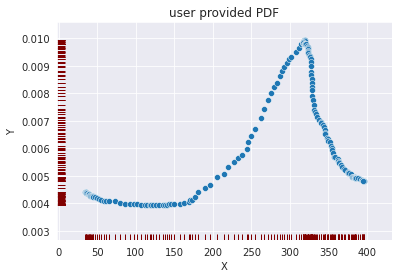

In [6]:
sns.scatterplot(x=point_df.X,y=point_df.Y)
sns.rugplot(x=point_df.X,y=point_df.Y,color='maroon')
plt.title('user provided PDF')

/tmp/ipykernel_7207/3802735747.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  point_df.resampled_x = np.linspace(int(point_df.X.min()), int(point_df.X.max()), point_df.shape[0])


<AxesSubplot:ylabel='Y'>

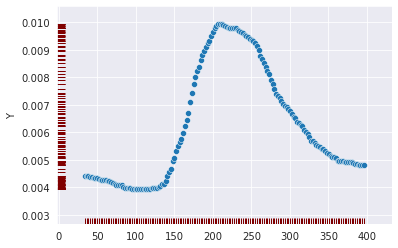

In [4]:
point_df.resampled_x = np.linspace(int(point_df.X.min()), int(point_df.X.max()), point_df.shape[0])
sns.scatterplot(x=point_df.resampled_x, y=point_df.Y)
#sns.scatterplot(x=point_df.X, y=point_df.Y, color='orange')
sns.rugplot(x=point_df.resampled_x,y=point_df.Y,color='maroon')


In [5]:
np.histogram(point_df.resampled_x)

def point_table_to_hist(point_df,num_bins):
    heights = []
    points_per_bin = point_df.shape[0]//num_bins
    for bin_i in range(points_per_bin,point_df.shape[0],points_per_bin):
        last_i = max(0,bin_i - points_per_bin)
        height = point_df.iloc[last_i:bin_i,:].Y.mean()
        heights.append(height)
    return np.array(heights), np.linspace(point_df.X.min(),point_df.X.max(),num_bins)
    
#todo make bins automatic


In [6]:
bin_edges= hist[1]
bin_edges[:-1] > bin_edges[1:]
hist[1]

NameError: name 'hist' is not defined

In [7]:
point_table_to_hist(point_df, num_bins=20)

(array([0.00436568, 0.00425364, 0.00407294, 0.00394646, 0.00393923,
        0.00410908, 0.00518243, 0.00695689, 0.00883254, 0.00980109,
        0.00979386, 0.0095192 , 0.00887591, 0.00769414, 0.00686293,
        0.00621964, 0.0055872 , 0.0052005 , 0.00493307]),
 array([ 34.        ,  53.05263158,  72.10526316,  91.15789474,
        110.21052632, 129.26315789, 148.31578947, 167.36842105,
        186.42105263, 205.47368421, 224.52631579, 243.57894737,
        262.63157895, 281.68421053, 300.73684211, 319.78947368,
        338.84210526, 357.89473684, 376.94736842, 396.        ]))

/home/owleyes/anaconda3/envs/drawprob/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


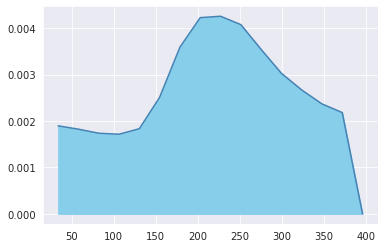

In [8]:
n_b = 16
hist = point_table_to_hist(point_df,num_bins=n_b)


hist_dist = sp.rv_histogram(hist)

X = np.linspace(point_df.X.min(),point_df.X.max(),n_b)

sns.lineplot(hist[1],hist_dist.pdf(X),color='steelblue',alpha=1,)
#(hist[0].size,hist[1].size)
plt.fill_between(x=X,y1=hist_dist.pdf(X),y2=[0]*X.shape[0], color='skyblue', interpolate=True)

Text(0.5, 1.0, 'CDF')

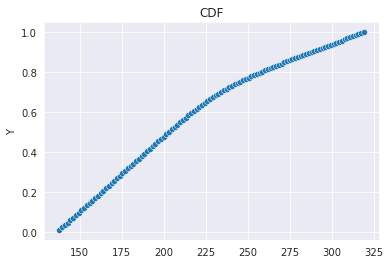

In [8]:
#remove half of the points maybe?
half=point_df.sample(point_df.shape[0]//2)
sns.scatterplot(x=point_df.resampled_x,y=np.cumsum(point_df.Y))
plt.title('CDF')


In [9]:
#roulette wheel sampling
n = 10000
point_df.CDF_y = np.cumsum(point_df.Y)
samples = []

for i in range(n):
    roulette = np.random.uniform(0,1)
    #print(roulette)
    filtered_index = point_df.loc[point_df.CDF_y.apply(lambda x: x < roulette )]
    if filtered_index.shape[0] >= 1:

        samples.append(
                    point_df.iloc[filtered_index.iloc[-1]].X
                                  )       
point_df.samples = pd.Series(samples)

/tmp/ipykernel_22196/4121085393.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  point_df.CDF_y = np.cumsum(point_df.Y)


IndexError: positional indexers are out-of-bounds

In [10]:
filtered_index.iloc[-1].X

315.0

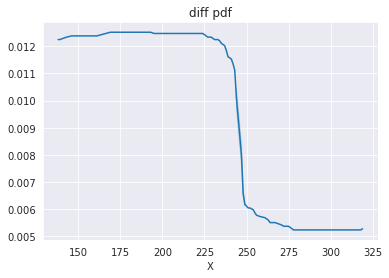

In [11]:
#by fundamental theorem of calculus, we differentiate CDF to get PDF
diff_pdf = np.diff(np.cumsum(point_df.Y))
renomalized_pdf = diff_pdf/diff_pdf.sum()
sns.lineplot(x=point_df.X.iloc[0:-1],y=renomalized_pdf)
_ = plt.title("diff pdf")

#sns.scatterplot(x=point_df.X.iloc[0:-1],y=renomalized_pdf)

Text(0.5, 1.0, 'Compounding probability of regulation')

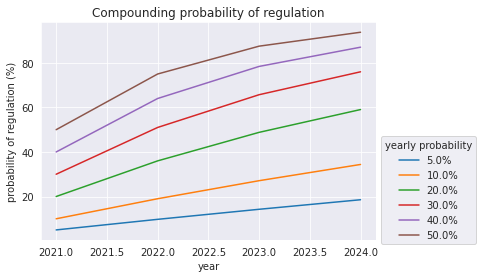

In [12]:
import scipy.stats as sp
x = []
reg_prob = [0.05,0.1,0.2,0.3,0.4,0.5]
for regulation_probability in reg_prob:
    l = []
    for i in range(1,5):
        l.append( (1-sp.binom(i,regulation_probability).pmf(0) )* 100)
    #pd.Series(l).plot()
    x.append(pd.Series(l))
big_x = pd.DataFrame(x).T
big_x.columns.name = 'yearly probability of regulation'
big_x.index = big_x.index + 2021
big_x.columns = [ f"{i* 100}%" for i in reg_prob ]
#sns.lineplot(big_x)
big_x.plot()
plt.ylabel('probability of regulation (%)')
plt.xlabel('year')
plt.legend(title='yearly probability',loc='upper left', bbox_to_anchor=(1, 0.5))
plt.title('Compounding probability of regulation')

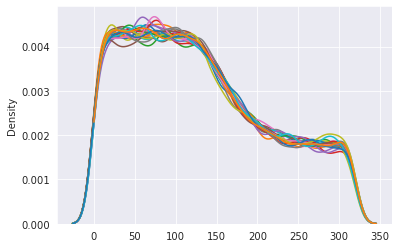

In [13]:
#test with np.random
x_lin = np.linspace(0,point_df.X.max(),renomalized_pdf.shape[0])
#fig,ax=plt.subplots(2,1)
fig, ax = plt.subplots()
for i in range(1,22):
    sample = np.random.choice(x_lin, size=10000,p=renomalized_pdf)
    my_kde = sns.kdeplot(sample,bw_method=0.1,bw_adjust=1)
    line = my_kde.lines[0]
    x, y = line.get_data()
#plt.show()
ax.plot(x[x>0], y[x>0])


In [ ]:
point_df.X

In [ ]:
import statsmodels.api as sm

dens = sm.nonparametric.KDEUnivariate(point_df.X)
dens.fit(fft=True,kernel='gau')
#x = np.linspace(0,1,200) #restrict range to (0,1)
#y = dens.evaluate(point_df.X.iloc[0:-1].to_numpy())
#plt.plot(x_lin,y)
#dens.cdf.sample(10000)
plt.plot(dens.pdf)


In [ ]:
plt.plot(np.diff(dens.cdf))

In [ ]:
sns.displot(x=point_df.X.iloc[0:-1],y=diff_pdf)


1. take in pdf points
2. integrate to approx CDF
3. do sampling from cdf:
    a. pick num between [0,1]. 
    b. go thru all n samples in CDFx. if CDFx_{n+1} > num and CDFx_{n} <= num, then sample x_n. 
    c. repeat until satisfied. 

In [ ]:
CDFx = np.cumsum(point_df.Y)
#point_df.X.hist(bins=60)
plt.hist(np.random.choice(point_df.X,size=1000, p=point_df.Y),bins=60)

In [ ]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.7).fit(point_df)
#kde.score_samples( np.zeros((1, 1)))

In [ ]:
#sns.histplot(samples,bins=50)
#sns.scatterplot(x= CDFx.index,y=CDFx.CDFx)

In [ ]:
#
sns.kdeplot(x=point_df.Y,color='maroon')
sns.rugplot(x=point_df.Y)

In [ ]:
#sns.kdeplot(x=CDFx.CDFx,bw_adjust=0.2)
sns.kdeplot(x=point_df.X,bw_adjust=0.8)
#sns.scatterplot(x=point_df["X"],y=point_df['Y'])

total_log_prob: 0.0
total_log_prob: 0.0
total_log_prob: 0.0


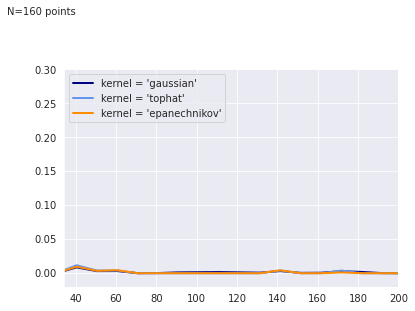

In [111]:
X_plot = np.linspace(0, 1000, 100)[:, np.newaxis]

fig, ax = plt.subplots()
#ax.fill(X_plot[:, 0], true_dens, fc='black', alpha=0.2,
#        label='input distribution')
colors = ['navy', 'cornflowerblue', 'darkorange']
kernels = ['gaussian', 'tophat', 'epanechnikov']
lw = 2

X = point_df.X.to_numpy().reshape(-1,1)
for color, kernel in zip(colors, kernels):
    kde = KernelDensity(kernel=kernel, bandwidth=0.8).fit(X)
    log_dens = kde.score_samples(X_plot)
    print(f"total_log_prob: {np.exp(kde.score(X))}")
    ax.plot(X_plot[:, 0], np.exp(log_dens), color=color, lw=lw,
            linestyle='-', label="kernel = '{0}'".format(kernel))

ax.text(6, 0.38, "N={0} points".format(point_df.shape[0]))

ax.legend(loc='upper left')
#ax.plot(point_df.X[:, 0], -0.005 - 0.01 * np.random.random(point_df.X.shape[0]), '+k')z

ax.set_xlim(min(X), X.shape[0]+40)
ax.set_ylim(-0.02, 0.3)
plt.show()

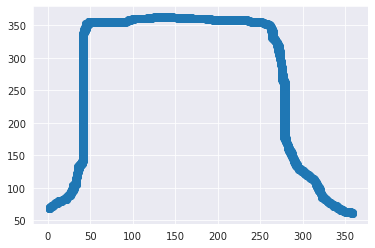

In [101]:
debug_df = pd.read_csv("debug.csv",index_col=0)

debug_df.sort_values(by='X',inplace=True)
#sns.scatterplot(data=debug_df,x='X',y='Y')
def point_table_to_hist(point_df, num_bins):
    point_df.sort_values(by='X',inplace=True)
    heights = []
    x_range = [0]
    points_per_bin = point_df.shape[0]//(num_bins)
    for bin_i in range(points_per_bin, point_df.shape[0], points_per_bin):
        last_i = max(0, bin_i - points_per_bin)
        #print(point_df.iloc[last_i:bin_i, :].X.median())
        x_range.append(point_df.iloc[last_i:bin_i, :].X.median())
        height = point_df.iloc[last_i:bin_i, :].Y.mean()
        heights.append(height)
    return np.array(heights), np.array(x_range) #np.linspace(point_df.X.min(), point_df.X.max(), num_bins)

hist = point_table_to_hist(debug_df,10)
hist_dist = sp.rv_histogram(hist)



#sns.displot(hist_dist.rvs(size=10000),bins=10)
#hist[0].shape,hist[1].shape
plt.scatter(debug_df.X, -debug_df.Y +400)
#sns.rugplot(x=debug_df.X,y=debug_df.Y,color='maroon')


In [24]:
from fitter import get_common_distributions
samples = hist_dist.rvs(size=1000)
np.min(samples)

NameError: name 'hist_dist' is not defined

/home/owleyes/anaconda3/envs/drawprob/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:4837: IntegrationWarning:

The integral is probably divergent, or slowly convergent.

/home/owleyes/anaconda3/envs/drawprob/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning:

The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.

/home/owleyes/anaconda3/envs/drawprob/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning:

The integral is probably divergent, or slowly convergent.



,sumsquare_error,aic,bic,kl_div
genextreme,0.000004,127.153361,-19297.479954,0.038135
pearson3,0.000004,127.870081,-19248.061404,0.041277
johnsonsu,0.000004,130.033969,-19219.137023,0.043267
triang,0.000004,126.414049,-19223.372022,0.035331
powernorm,0.000004,128.115950,-19218.853839,0.043542


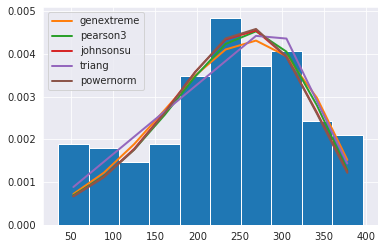

In [142]:
f = Fitter(samples,bins=10)#distributions=["halfgennorm","nakagami",'genhalflogistic','truncexpon','beta'])
f.fit()
f.summary()

(4.704509176869287, 0.0004921633866305224, 0.00034863754622526234)

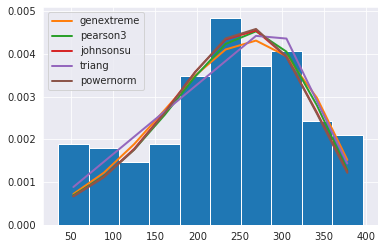

In [143]:
summ = f.summary()
params

In [146]:

X = np.linspace(np.min(hist_dist.rvs(size=1000)),np.max(hist_dist.rvs(size=1000)),25)

trace2 = go.Histogram(x=hist_dist.rvs(size=1000),nbinsx=10,
                      name='Input Distribution',opacity=0.6,histnorm='probability density')
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(trace2)


for pdf in pdf_dict.keys():
    trace = go.Scatter(x=X,y=pdf_dict[pdf], name=f'{pdf} best fit')
    fig.add_trace(trace,secondary_y=True)
fig.update_layout(bargap=0.01)
fig.show()

NameError: name 'im' is not defined

In [47]:
import scipy.stats
dist = scipy.stats.nakagami
params = f.fitted_param['nakagami']
X = np.linspace(10,400,25)
pdf_fitted = dist.pdf(X,*params)

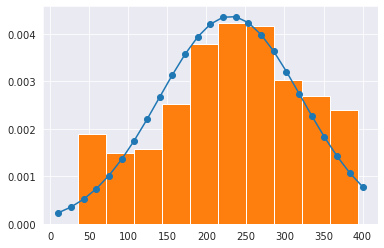

In [100]:
plt.plot(X, pdf_fitted, 'o-')
plt.hist(samples,density=True)
plt.show()

<AxesSubplot:ylabel='Density'>

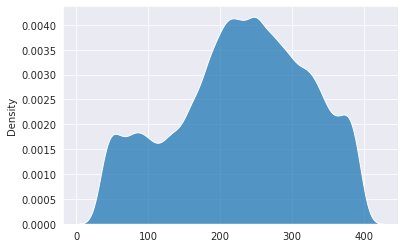

In [37]:
sns.kdeplot(hist_dist.rvs(size=10000),bw_adjust=0.7,multiple='stack')

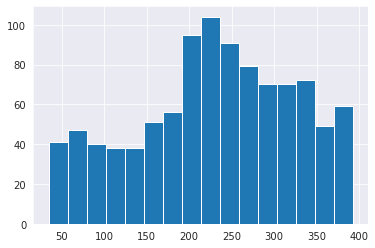

In [21]:
_=plt.hist(hist_dist.rvs(size=1000),bins=16)

In [118]:
hist_dist.

AttributeError: 'rv_histogram' object has no attribute 'bins'